# Health Insurance Price Forecast

![](img/poster.jpg)

Today, as prices rise for basic necessities, we need to have a way to check beforehand what we will spend our money on. For medical insurance we can take a look at various features to arrive at a price for customers. This is what we'll do in this project, from prediction to deployment.

Our data was obtained from this [Kaggle problem on Medical Cost - Insurance Forecast](https://www.kaggle.com/mirichoi0218/insurance), in which we have the question of **"Can you accurately predict insurance costs?"**

> For ease of access, the data was upload to GitHub [here](https://github.com/diascarolina/project-insurance-forecast/blob/main/insurance.csv).

# 1 Libraries and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import pickle

In [2]:
# source: https://github.com/empathy87/storytelling-with-data

# colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# fonts
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'

In [3]:
# setting random state
rs = 42847

# 2 Functions

In [4]:
def run_model(model, print_values = 1, return_predictions = 0):
    """
    Function that receives a machine learning model and returns its metrics.
    
    print_values = 1: print the results of the calculated metrics
    return_predictions = 1: returns the y predictions together with the metrics
    """
    model.fit(X_train, y_train)
    y_predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_predictions)
    mse = mean_squared_error(y_test, y_predictions)
    rmse = np.sqrt(mse)
    if print_values:
        print(f"MAE: {round(mae, 3)}")
        print(f"MSE: {round(mse, 3)}")
        print(f"RMSE: {round(rmse, 3)}")
    if return_predictions:
        return y_predictions, mae, mse, rmse
    return mae, mse, rmse

# 3 Data Checking and Cleaning

Let's first load our data. It was downloaded from [the Kaggle problem page](https://www.kaggle.com/mirichoi0218/insurance) and uploaded to GitHub for easy access.

In [5]:
df = pd.read_csv('insurance.csv')

Checking the first few line of the dataset:

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


From this we see that we have the following information (adapted from the Kaggle problem description):
- **age**: age of primary beneficiary;
- **sex**: insurance contractor gender, female, male;
- **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight $(kg/m^2)$ using the ratio of height to weight, ideally 18.5 to 24.9;
- **children**: Number of children covered by health insurance / Number of dependents;
- **smoker**: if that person smokes or not;
- **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest;
- **charges**: Individual medical costs billed by health insurance.

In [7]:
print(f'Numer of rows: {df.shape[0]}')
print(f'Numer of columns: {df.shape[1]}')

Numer of rows: 1338
Numer of columns: 7


Let's check missing values:

In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Since this is a Kaggle dataset, it is already pretty clean.

Information about the columns:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Statistics about the values:

In [10]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From this we see that the youngest person in the dataset is 18 years old and the oldest is 64 years old.

The average BMI is around 30.66, which is pretty high compared to the ideal BMI of 18.5 to 24.9.

The person that has most children in this dataset has 5 children.

The lowest insurance charge is 1121.87 USD and the highest is 63770.42 USD.

# 4 Exploratory Data Analysis

In this step, let's first check the distribution of the variables, to see if everything's in order.

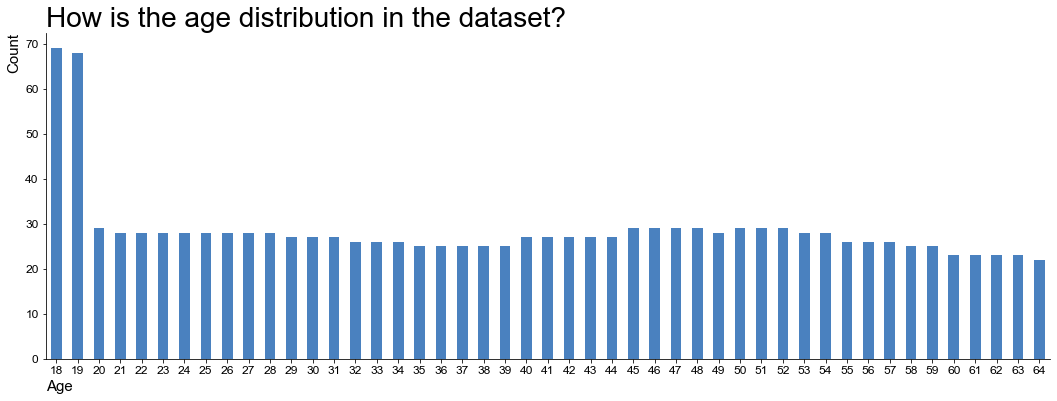

In [11]:
df.age.value_counts().sort_index(ascending = True).plot(kind = 'bar', figsize = (18, 6), color = BLUE2)
plt.title('How is the age distribution in the dataset?', fontdict = {'fontsize': 28}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Age', fontsize = 15, loc = 'left')
plt.ylabel('Count', fontsize = 15, loc = 'top')
sns.despine()
plt.show()

It seems that the are approximately 30 people with each age, except for 18 and 19 years old, which seems to have almost 70 people each.

Now for the gender distribution between men and women.

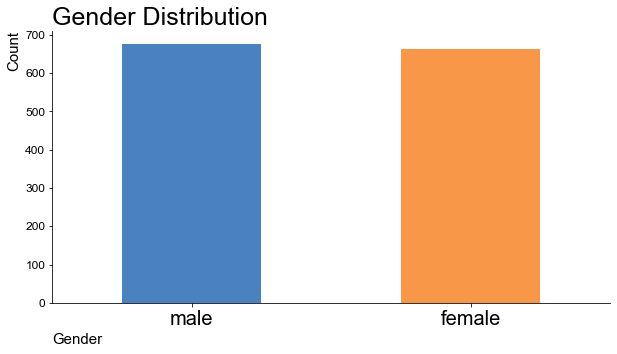

In [12]:
df.sex.value_counts().plot(kind = 'bar', figsize = (10, 5), color = [BLUE2, ORANGE1])
plt.title('Gender Distribution', fontdict = {'fontsize': 25}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 12)
plt.xlabel('Gender', fontsize = 15, loc = 'left')
plt.ylabel('Count', fontsize = 15, loc = 'top')
sns.despine()
plt.show()

The distribution is almost 50-50. Let's check:

In [13]:
percentage_female = (df['sex'] == 'female').sum() / len(df) * 100
percentage_male = (df['sex'] == 'male').sum() / len(df) * 100

print(f'Percentage of female: {round(percentage_female, 2)}%')
print(f'Percentage of male: {round(percentage_male, 2)}%')

Percentage of female: 49.48%
Percentage of male: 50.52%


What about the distribution of the BMI?

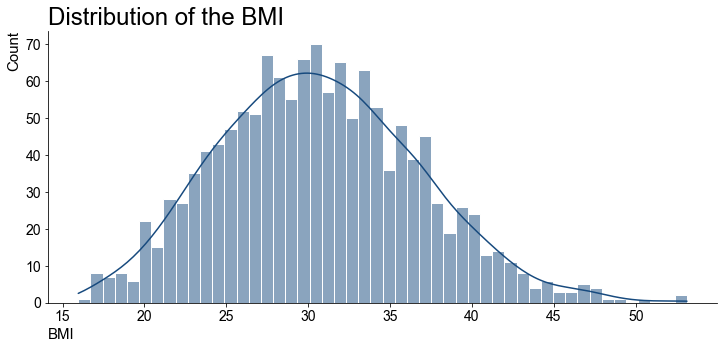

In [14]:
plt.figure(figsize = (12, 5))
plt.title("Distribution of the BMI", fontdict = {'fontsize': 24}, loc = 'left')
sns.set_style("white")
ax = sns.histplot(df.bmi, kde = True, bins = 50, color = BLUE1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('BMI', fontsize = 15, loc = 'left')
plt.ylabel('Count', fontsize = 15, loc = 'top')
sns.despine()
plt.show()

We have a pretty even distribution (to the naked eye), centered at around 30.

Is the number of children a person has well distributed?

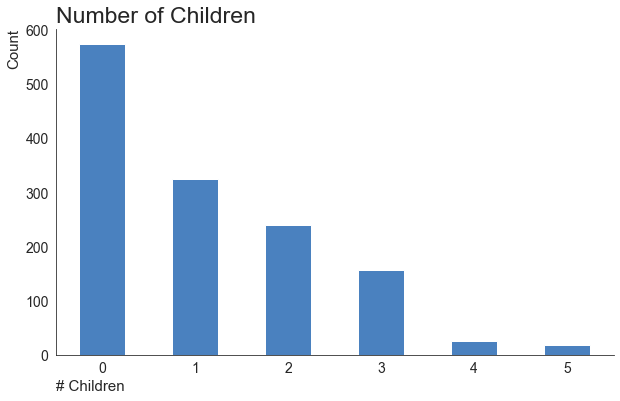

In [15]:
df.children.value_counts().sort_index().plot(kind = 'bar', figsize = (10, 6), color = BLUE2)
plt.title('Number of Children', fontdict = {'fontsize': 23}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('# Children', fontsize = 15, loc = 'left')
plt.ylabel('Count', fontsize = 15, loc = 'top')
sns.despine()
plt.show()

Let's check some values:

In [16]:
percentage_with_children = (df['children'] != 0).sum() / len(df) * 100
percentage_no_children = (df['children'] == 0).sum() / len(df) * 100

print(f'Percentage of people with no children: {round(percentage_no_children, 2)}%')
print(f'Percentage of people with one or more children: {round(percentage_with_children, 2)}%')

Percentage of people with no children: 42.9%
Percentage of people with one or more children: 57.1%


Do we have more smokers or non-smokers?

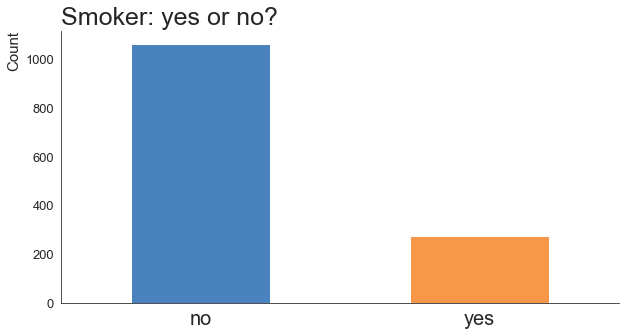

In [17]:
df.smoker.value_counts().plot(kind = 'bar', figsize = (10, 5), color = [BLUE2, ORANGE1])
plt.title('Smoker: yes or no?', fontdict = {'fontsize': 25, 'fontweight': 'medium'}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 13)
plt.ylabel('Count', fontsize = 15, loc = 'top')
sns.despine()
plt.show()

We have significantly less non-smokers in our dataset than smokers.

Are the regions well distributed?

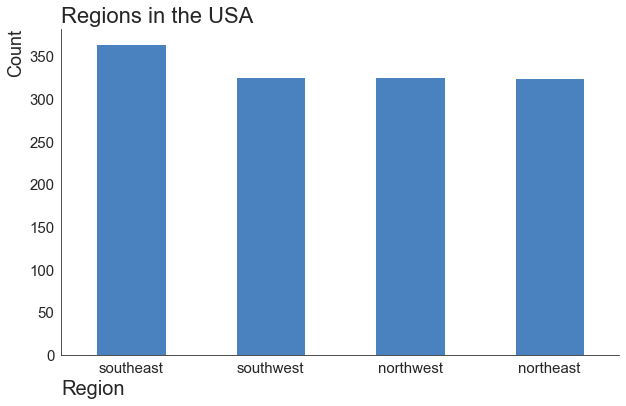

In [18]:
df.region.value_counts().plot(kind = 'bar', figsize = (10, 6), color = BLUE2)
plt.title('Regions in the USA', fontdict = {'fontsize': 22, 'fontweight': 'medium'}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Region', fontsize = 20, loc = 'left')
plt.ylabel('Count', fontsize = 18, loc = 'top')
sns.despine()
plt.show()

The regions are pretty well distributed.

Finally, let's see how the variable that we want to predict is distributed.

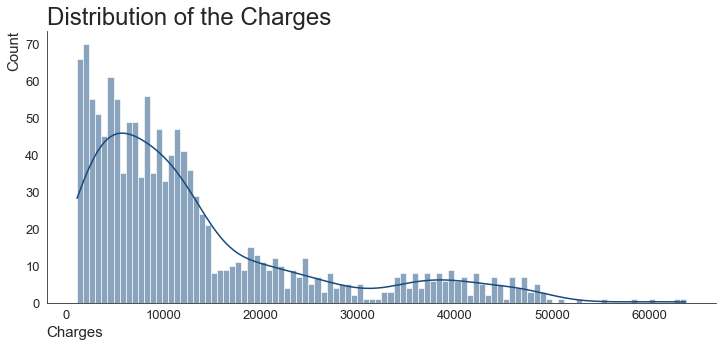

In [19]:
plt.figure(figsize = (12, 5))
plt.title("Distribution of the Charges", fontdict = {'fontsize': 24}, loc = 'left')
sns.set_style("white")
ax = sns.histplot(df.charges, kde = True, bins = 100, color = BLUE1)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('Charges', fontsize = 15, loc = 'left')
plt.ylabel('Count', fontsize = 15, loc = 'top')
sns.despine()
plt.show()

We have a distrubution skewed to the right here in the charges, which means that the majority of people pay less than 15000 USD in insurance.

Now let's check each variable against the charges to see how they relate.

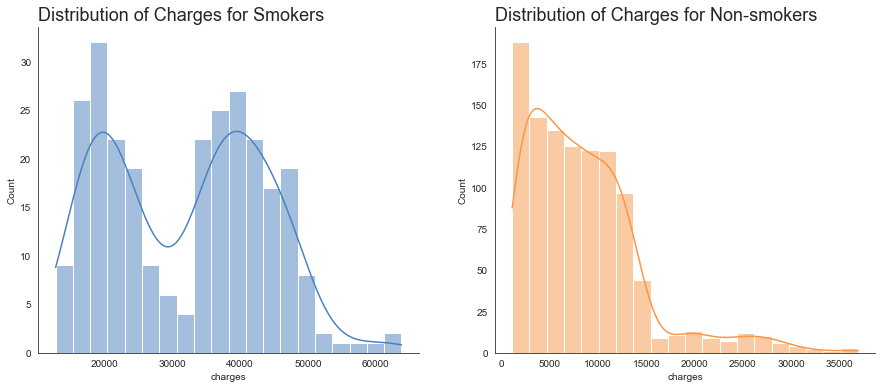

In [20]:
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(121)
sns.histplot(df[(df.smoker == 'yes')]['charges'], color = BLUE2, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for Smokers', fontdict = {'fontsize': 18}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.smoker == 'no')]['charges'], color = ORANGE1, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for Non-smokers', fontdict = {'fontsize': 18}, loc = 'left')

sns.despine()

plt.show()

We see that the charges are significantly higher for smokers.

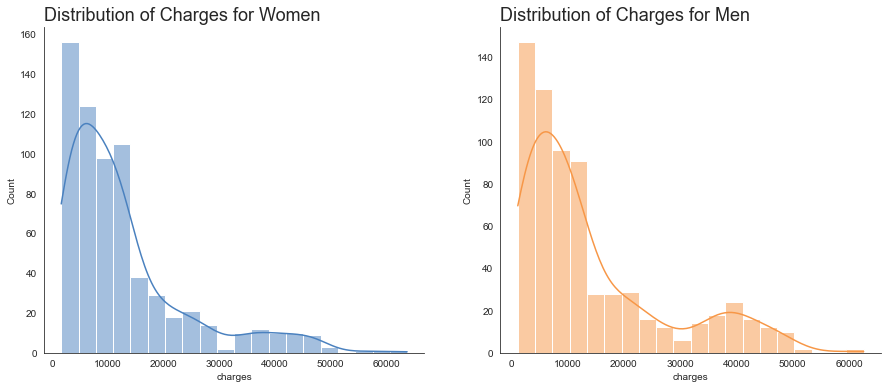

In [22]:
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(121)
sns.histplot(df[(df.sex == 'female')]['charges'], color = BLUE2, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for Women', fontdict = {'fontsize': 18}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.sex == 'male')]['charges'], color = ORANGE1, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for Men', fontdict = {'fontsize': 18}, loc = 'left')

sns.despine()

plt.show()

Visually, there's not much of a difference in charges for men and women.

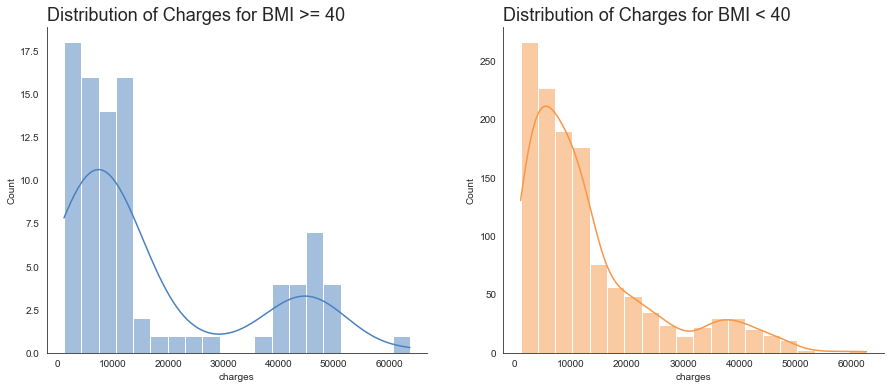

In [23]:
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(121)
sns.histplot(df[(df.bmi >= 40)]['charges'], color = BLUE2, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for BMI >= 40', fontdict = {'fontsize': 18}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.bmi < 40)]['charges'], color = ORANGE1, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for BMI < 40', fontdict = {'fontsize': 18}, loc = 'left')

sns.despine()

plt.show()

A BMI of 40 or more falls under the category of severe obesity, so it makes sense for people in this range to have higher prices in insurance.

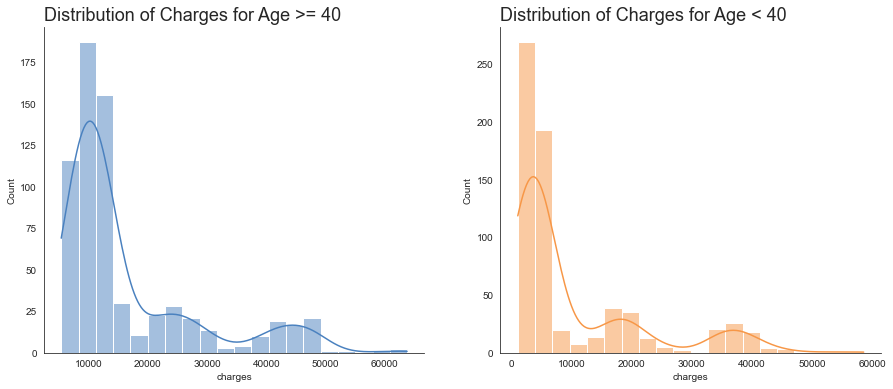

In [24]:
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(121)
sns.histplot(df[(df.age >= 40)]['charges'], color = BLUE2, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for Age >= 40', fontdict = {'fontsize': 18}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.age < 40)]['charges'], color = ORANGE1, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for Age < 40', fontdict = {'fontsize': 18}, loc = 'left')

sns.despine()

plt.show()

The charges distribution by age is about the same, but just a bit higher in 40 years old or more.

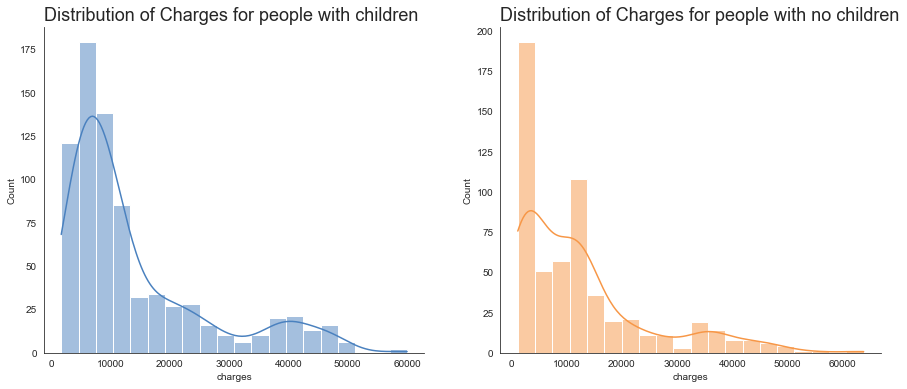

In [25]:
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(121)
sns.histplot(df[(df.children != 0)]['charges'], color = BLUE2, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for people with children', fontdict = {'fontsize': 18}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.children == 0)]['charges'], color = ORANGE1, ax = ax, kde = True, bins = 20)
ax.set_title('Distribution of Charges for people with no children', fontdict = {'fontsize': 18}, loc = 'left')

sns.despine()

plt.show()

People with children pay more in insurance prices.

## 4.1 Feature Importance

Here we'll check how the data correlates with each other.

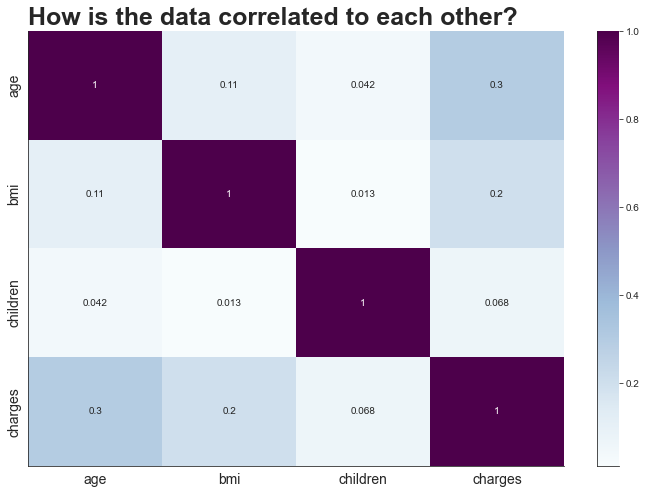

In [26]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), cmap = "BuPu", annot = True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('How is the data correlated to each other?', fontdict = {'fontsize': 25, 'fontweight': 'bold'}, loc = 'left')
sns.despine()
plt.show()

There's not really a significant correlation between the numerical variables.

Let's check how the variables influence the charges.

In [27]:
df_corr = df.copy()

In [28]:
age_corr = df_corr['age'].corr(df_corr['charges'])
print(f'The correlation between age and charges is {round(age_corr, 3)}.')

The correlation between age and charges is 0.299.


In [29]:
df_corr.sex = df_corr.sex.map({"female": 0, "male": 1})
gender_corr = df_corr['sex'].corr(df_corr['charges'])
print(f'The correlation between gender and charges is {round(gender_corr, 3)}.')

The correlation between gender and charges is 0.057.


In [30]:
bmi_corr = df_corr['bmi'].corr(df_corr['charges'])
print(f'The correlation between BMI and charges is {round(bmi_corr, 3)}.')

The correlation between BMI and charges is 0.198.


In [31]:
children_corr = df_corr['children'].corr(df_corr['charges'])
print(f'The correlation between the number of children and the charges is {round(children_corr, 3)}.')

The correlation between the number of children and the charges is 0.068.


In [32]:
df_corr.smoker = df_corr.smoker.map({"yes": 1, "no": 0})
smoker_corr = df_corr['smoker'].corr(df_corr['charges'])
print(f'The correlation between smoking and charges is {round(smoker_corr, 3)}.')

The correlation between smoking and charges is 0.787.


The "region" column is trickier to check the correlation against the charges because we don't have a binary variable. We can use some statistical tests to check the correlation, but checking manually (changing the values for the mapping) gives us somewhat similar results: very low correlation between the region and the charges.

In [33]:
df_corr.region = df_corr.region.map({'southwest': 4, 'southeast': 3, 'northwest': 1, 'northeast': 2})
region_corr = df_corr['region'].corr(df_corr['charges'])
print(f'The correlation between the regions and the charges is {round(region_corr, 3)}.')

The correlation between the regions and the charges is 0.012.


From this we see that the variable that most affects is if someone smokes or not, followed by a person's age and BMI. All of this makes sense in the "real world".

# 5 Model Prediction

## 5.1 Data Preparation

Here we will change the categorical variables to numerical (but still categorical) variables. We'll do this by mapping each word to a value. It's preferable to encode the variables using One Hot Encoding, but for the purpose of this project we'll do a simple mapping.

In [34]:
df.sex = df.sex.map({"female": 0, "male": 1})
df.region = df.region.map({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3})
df.smoker = df.smoker.map({"yes": 1, "no": 0})

Getting our X and y...

In [35]:
X = df.drop('charges', axis = 1)
y = df.charges

Splitting the data...

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

In [37]:
print(f'X train size: {len(X_train)} || y train size: {len(y_train)}')
print(f'X test size: {len(X_test)} || y train size: {len(y_test)}')

X train size: 1003 || y train size: 1003
X test size: 335 || y train size: 335


As seen above, we split our data only in two parts, train and test, without the validation part. We'll still validate our results, but we'll do it in the test set, seeing as our dataset has a small number of data points at our disposal.

## 5.2 Machine Learning: Modelling and Tuning

In this part we'll use a variety of regression models in our data to predict the charges. Our chosen metric is the Root Mean Squared Error (RMSE), because it gives a good insight about how our prediction is doing, but we'll also take a look at the Mean Absolute Value (MAE) and the Mean Squared Error (MSE).

### Model 0: Dummy Model

It's always good to have a baseline to check our future models. Here we'll predict, for new values, the average of the charges.

In [38]:
dummy = DummyRegressor(strategy = 'mean')

In [39]:
mae_dummy, mse_dummy, rmse_dummy = run_model(dummy)

MAE: 9668.122
MSE: 174387341.422
RMSE: 13205.58


### Model 1: Linear Regression

In [40]:
linreg = LinearRegression()

In [41]:
mae_linreg, mse_linreg, rmse_linreg = run_model(linreg)

MAE: 4532.344
MSE: 43075124.028
RMSE: 6563.164


There's not much tuning we can do in a simple linear regression, so we'll go ahead to the next models.

### Model 2: RandomForestRegressor

In [42]:
randomreg = RandomForestRegressor(random_state = rs)

In [43]:
mae_rfr, mse_rfr, rmse_rfr = run_model(randomreg)

MAE: 2773.741
MSE: 27811593.691
RMSE: 5273.67


#### RandomForestRegressor Tuning

Here we'll use `GredSearchCV` to find possible best candidate for hyperparameters in our model. It tests a combination of values and returns the best one.

In [44]:
randomreg = RandomForestRegressor(random_state = rs)

params = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [10, 50, 100],
    'bootstrap': [True, False]
}

rfr_search = GridSearchCV(randomreg,
                          params, 
                          scoring = 'neg_root_mean_squared_error',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

rfr_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestRegressor(random_state=42847), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [10, 50, 100],
                         'n_estimators': [20, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [45]:
rfr_search.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 50,
 'n_estimators': 20}

In [46]:
rfr_model = rfr_search.best_estimator_
mae_rfr, mse_rfr, rmse_rfr = run_model(rfr_model)

MAE: 2860.878
MSE: 26120557.91
RMSE: 5110.828


### Model 3: Ridge Regression

In [47]:
ridge = Ridge(random_state = rs)
mae_ridge, mse_ridge, rmse_ridge = run_model(ridge)

MAE: 4542.96
MSE: 43100886.662
RMSE: 6565.127


#### Ridge Regression Tuning

In [48]:
for i in [0.001, 0.01, 0.1, 0.5, 1.0, 10, 100]:
    ridge = Ridge(random_state = rs, alpha = i)
    print(f'alpha = {i}')
    run_model(ridge)
    print("---")

alpha = 0.001
MAE: 4532.355
MSE: 43075145.574
RMSE: 6563.166
---
alpha = 0.01
MAE: 4532.451
MSE: 43075339.877
RMSE: 6563.181
---
alpha = 0.1
MAE: 4533.41
MSE: 43077320.96
RMSE: 6563.332
---
alpha = 0.5
MAE: 4537.659
MSE: 43086957.264
RMSE: 6564.066
---
alpha = 1.0
MAE: 4542.96
MSE: 43100886.662
RMSE: 6565.127
---
alpha = 10
MAE: 4640.135
MSE: 43666376.453
RMSE: 6608.054
---
alpha = 100
MAE: 5481.88
MSE: 60500857.665
RMSE: 7778.23
---


Best alpha from above (that gives us the lowest RMSE):

In [49]:
ridge = Ridge(random_state = rs, alpha = 0.001)
mae_ridge, mse_ridge, rmse_ridge = run_model(ridge)

MAE: 4532.355
MSE: 43075145.574
RMSE: 6563.166


### Model 4: Lasso Regression

In [50]:
lasso = Lasso(random_state = rs)
mae_lasso, mse_lasso, rmse_lasso = run_model(lasso)

MAE: 4532.579
MSE: 43074041.263
RMSE: 6563.082


#### Lasso Regression Tuning

In [51]:
for i in [0.001, 0.01, 0.1, 0.5, 1.0, 10, 100]:
    lasso = Lasso(random_state = rs, alpha = i)
    print(f'alpha = {i}')
    run_model(lasso)
    print("---")

alpha = 0.001
MAE: 4532.344
MSE: 43075122.934
RMSE: 6563.164
---
alpha = 0.01
MAE: 4532.346
MSE: 43075113.094
RMSE: 6563.163
---
alpha = 0.1
MAE: 4532.368
MSE: 43075014.734
RMSE: 6563.156
---
alpha = 0.5
MAE: 4532.461
MSE: 43074579.948
RMSE: 6563.123
---
alpha = 1.0
MAE: 4532.579
MSE: 43074041.263
RMSE: 6563.082
---
alpha = 10
MAE: 4535.494
MSE: 43072274.388
RMSE: 6562.947
---
alpha = 100
MAE: 4569.692
MSE: 43154246.476
RMSE: 6569.189
---


Best alpha from above (that gives us the lowest RMSE):

In [52]:
lasso = Lasso(random_state = rs, alpha = 10)
mae_lasso, mse_lasso, rmse_lasso = run_model(lasso)

MAE: 4535.494
MSE: 43072274.388
RMSE: 6562.947


### Model 5: Bayesian Ridge Regression

In [53]:
bayrid = BayesianRidge()
mae_br, mse_br, rmse_br = run_model(bayrid)

MAE: 4536.282
MSE: 43083681.535
RMSE: 6563.816


#### Bayesian Ridge Regression Tuning

In [54]:
bayrid = BayesianRidge()

params = {
    'n_iter': [5, 10, 100],
    'alpha_init':[0.1, 0.5, 1],
    'lambda_init': [1, 1e-1, 1e-2, 1e-3]
}

bayrid_search = GridSearchCV(bayrid,
                          params, 
                          scoring = 'neg_root_mean_squared_error',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

bayrid_search.fit(X_train, y_train)

print(bayrid_search.best_params_)
bayrid_search = bayrid_search.best_estimator_
mae_br, mse_br, rmse_br = run_model(bayrid_search)

{'alpha_init': 0.5, 'lambda_init': 0.1, 'n_iter': 5}
MAE: 4536.282
MSE: 43083681.535
RMSE: 6563.816


### Model 6: Support Vector Regression

In [55]:
svr = SVR()
mse_svr, mse_svr, rmse_svr = run_model(svr)

MAE: 9470.772
MSE: 200933661.591
RMSE: 14175.107


#### Support Vector Regression Tuning

In [56]:
svr = SVR()

params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'coef0': [100, 500],
    'C': [10, 20],
    'epsilon': [0.1, 0.01]
}

svr_search = GridSearchCV(svr,
                          params, 
                          scoring = 'neg_root_mean_squared_error',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

svr_search.fit(X_train, y_train)

print(svr_search.best_params_)
svr_search = svr_search.best_estimator_
mse_svr, mse_svr, rmse_svr = run_model(svr_search)

{'C': 20, 'coef0': 100, 'degree': 4, 'epsilon': 0.01, 'kernel': 'poly'}
MAE: 3143.664
MSE: 34501865.925
RMSE: 5873.829


# 6 Models Results

Let's finally compare all our models.

In [57]:
metrics = {
    'DummyModel': rmse_dummy,
    'LinearRegression': rmse_linreg,
    'RandomForestRegressor': rmse_rfr,
    'RidgeRegression': rmse_ridge,
    'LassoRegression': rmse_lasso,
    'BayesianRegression': rmse_br,
    'SupportVectorRegression': rmse_svr
}

In [58]:
df_metrics = pd.DataFrame(metrics.items(), columns = ['Model', 'RMSE'])
df_metrics.sort_values('RMSE')

,Model,RMSE
2,RandomForestRegressor,5110.827517
6,SupportVectorRegression,5873.828898
4,LassoRegression,6562.947081
1,LinearRegression,6563.164178
3,RidgeRegression,6563.165819
5,BayesianRegression,6563.816080
0,DummyModel,13205.579935


From the above table, we see that the model that gives us the least _Root Mean Squared Error_ is the RandomForestRegressor. So let's go ahead and save it.

Last but not least, let's check which features where the most determinant for our model.

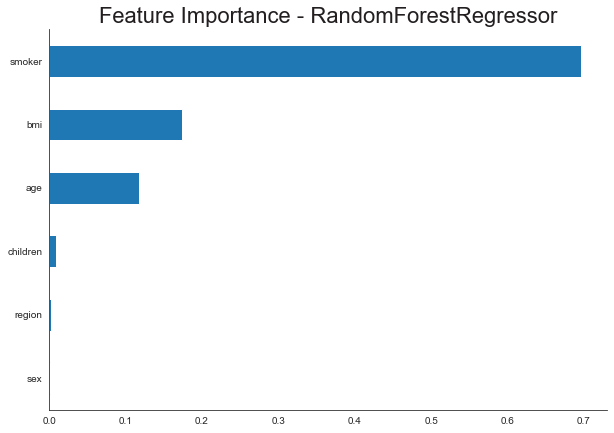

In [59]:
feat_import_rfr = pd.Series(rfr_model.feature_importances_, index = X_train.columns)
ax = feat_import_rfr.sort_values(ascending = True).plot(kind = 'barh', figsize = (10, 7))
plt.title('Feature Importance - RandomForestRegressor', fontsize = 22, color = GRAY1)
sns.despine()
plt.show()

As we've seen before, the variables "smoker", "bmi" and "age" all play an important part in the prediction.

# 7 Saving the Model

Our best model is the **"rfr_model"**, the RandomForestRegressor model obtained from the GridSearchCV.

In [ ]:
model = rfr_model
output_file = 'model_randomforestregressor.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump(model, f_out)

# 8 Conclusion

We've that the variables that most influence the price of the health insurance are: smoker, age and BMI. By applying a machine learning model to our data, we've found that the RandomForestRegressor was the best in our case.

# 9 References

 - [Image by Olya Kobruseva on Pexels](https://www.pexels.com/pt-br/foto/calendario-flatlay-tendencia-flat-lay-dentro-de-casa-7163953/)
- [Machine Learning Zoomcamp](https://datatalks.club/courses/2021-winter-ml-zoomcamp.html)
- [ML Zoomcamp: Midterm Project info](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp/07-midterm-project)
- [Kaggle Original Problem](https://www.kaggle.com/mirichoi0218/insurance)
- [Markdown to HTML](https://markdowntohtml.com/)
- [Markdown CSS](https://markdowncss.github.io/)

# 10 Contacts

Any tips or suggestions? Feel free to contact me!

[<img src="https://img.shields.io/badge/diascarolina-000000?style=flat-square&logo=github&logoColor=white" />](https://github.com/diascarolina) [<img src="https://img.shields.io/badge/carodias-0A66C2?style=flat-square&logo=linkedin&logoColor=white" />](https://www.linkedin.com/in/carodias/) [<img src="https://img.shields.io/badge/Gmail-EA4335?style=flat-square&logo=Gmail&logoColor=white" />](mailto:carolinadiasw@gmail.com)